<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Fadd-data-generators-to-fix-ram-problem/experiments/experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Experiment 3: Training an U-Net on the entire dataset

The goal of this notebook is to evaluate whether tile-overlapping has an effect on the resulting model.
We will use the exact same setup as in experiment 1 except for the dataset. Each tile has a size of (256, 256) and the step size is 256 to exclude overlap.

All previous experiments have only been used on a small part of the entire dataset. In this experiment all 16 images of
the entire dataset will be split into tiles and used as input for our model.

### 1. Prepare Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls
%cd drive/MyDrive/MachineLearning/Geospatial_ML
! ls

drive  sample_data
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio	 evaluation   notebooks     requirements.txt
combine_npz_files.ipynb  experiments  prepare_data
data_exploration	 models       README.md


In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pickle
from keras.utils import Sequence
from datetime import datetime

### Playgound Emely

In [6]:
data_path = "../data_colab/256_256"

total_tiles = 11121
train_tiles = total_tiles // 100 * 60 +1
test_val_tiles = total_tiles // 100 * 20 +1

train_set_x = np.memmap(os.path.join(data_path, "train_split_x.npy"), mode="r", shape=(train_tiles, 256, 256, 5), dtype=np.float32)
train_set_y = np.memmap(os.path.join(data_path, "train_split_y.npy"), mode="r", shape=(train_tiles, 256, 256), dtype=np.float32)
val_set_x = np.memmap(os.path.join(data_path, "test_split_x.npy"), mode="r", shape=(test_val_tiles, 256, 256, 5), dtype=np.float32)
val_set_y = np.memmap(os.path.join(data_path, "test_split_y.npy"), mode="r", shape=(test_val_tiles, 256, 256), dtype=np.float32)
test_set_x = np.memmap(os.path.join(data_path, "val_split_x.npy"), mode="r", shape=(test_val_tiles, 256, 256, 5), dtype=np.float32)
test_set_y = np.memmap(os.path.join(data_path, "val_split_y.npy"), mode="r", shape=(test_val_tiles, 256, 256), dtype=np.float32)

print(train_set_x.shape)
print(train_set_x.shape)
print(val_set_x.shape)
print(val_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)


(6661, 256, 256, 5)
(6661, 256, 256, 5)
(2221, 256, 256, 5)
(2221, 256, 256)
(2221, 256, 256, 5)
(2221, 256, 256)


In [7]:
class DataGenerator(Sequence):
    def __init__(self, mmap_x, mmap_y, batch_size):
        self.x_input = mmap_x
        self.y_mask = mmap_y
        self.batch_size = batch_size
        self.num_samples = self.x_input.shape[0]

    # returns number of batches as int    
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    # returns single batch
    def __getitem__(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]

        # normalization
        batch_inputs = batch_inputs/255
        # one-hot-encoding
        batch_masks = np.array([tf.one_hot(item, depth=3).numpy() for item in batch_masks])      
        
        # normalization + one hot encoding
        return batch_inputs, batch_masks
    
    def getitem_as_img(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]
        # normalization + one hot encoding
        return batch_inputs, batch_masks

In [8]:
# instanciate DataGenerators
batch_size = 32

train_generator = DataGenerator(train_set_x, train_set_y, batch_size)
val_generator = DataGenerator(val_set_x, val_set_y, batch_size)
test_generator = DataGenerator(test_set_x, test_set_y, batch_size)

print(train_generator.__len__())
print(val_generator.__len__())
print(test_generator.__len__())

209
70
70


In [9]:
train_batch = train_generator.__getitem__(9)
val_batch = val_generator.__getitem__(3)
test_batch = test_generator.__getitem__(4)

def print_batch_shapes(batch):
  print(type(batch))
  print(batch[0].shape)
  print(batch[1].shape)
  print()

# check batch shapes
print_batch_shapes(train_batch)
print_batch_shapes(val_batch)
print_batch_shapes(test_batch) 

# check normalization
print('Check normalization')
print(train_batch[1].max())
print(train_batch[1].min())

print(val_batch[1].max())
print(val_batch[1].min())

print(test_batch[1].max())
print(test_batch[1].min())

print()
# check one-hot-encoding
print('check one hot encoding')
print(train_batch[0].max())
print(train_batch[0].min())

print(val_batch[0].max())
print(val_batch[0].min())

print(test_batch[0].max())
print(test_batch[0].min())

# why unequal amount of elements in each set even though same batch size when instanciating DataGenerator?
# Bug in sanity check: one hot encoding max shoud be 2 instead of 1 => use function to check vector instead of single values of vector

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

Check normalization
1.0
0.0
1.0
0.0
1.0
0.0

check one hot encoding
1.0
0.0
1.0
0.0
1.0
0.0


### 2. Display Images

In [10]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

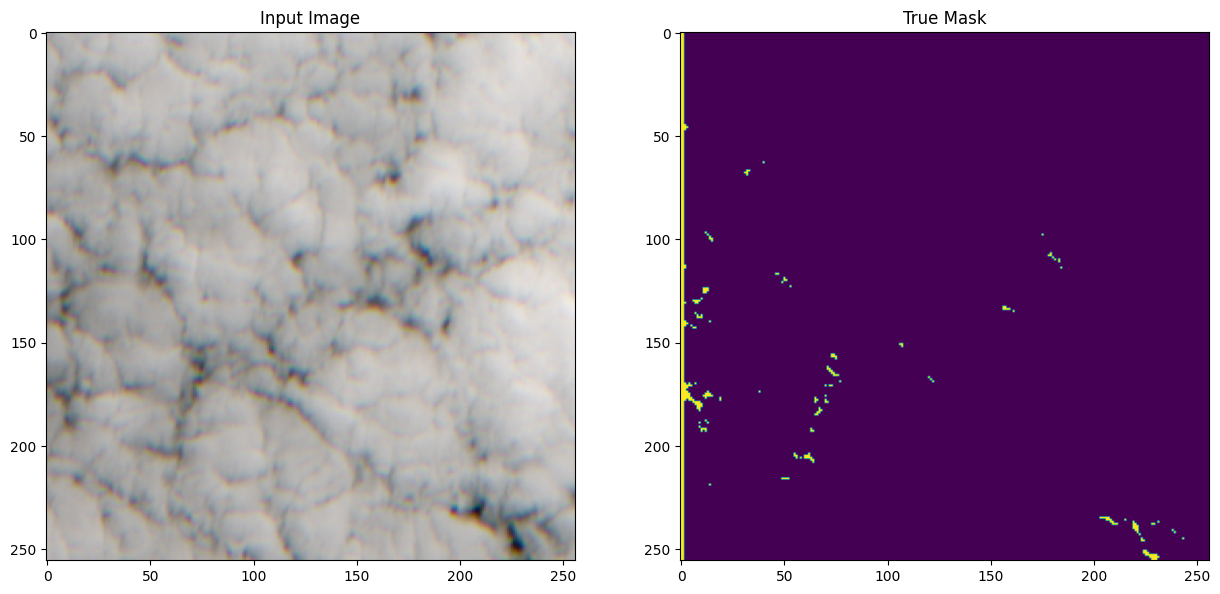

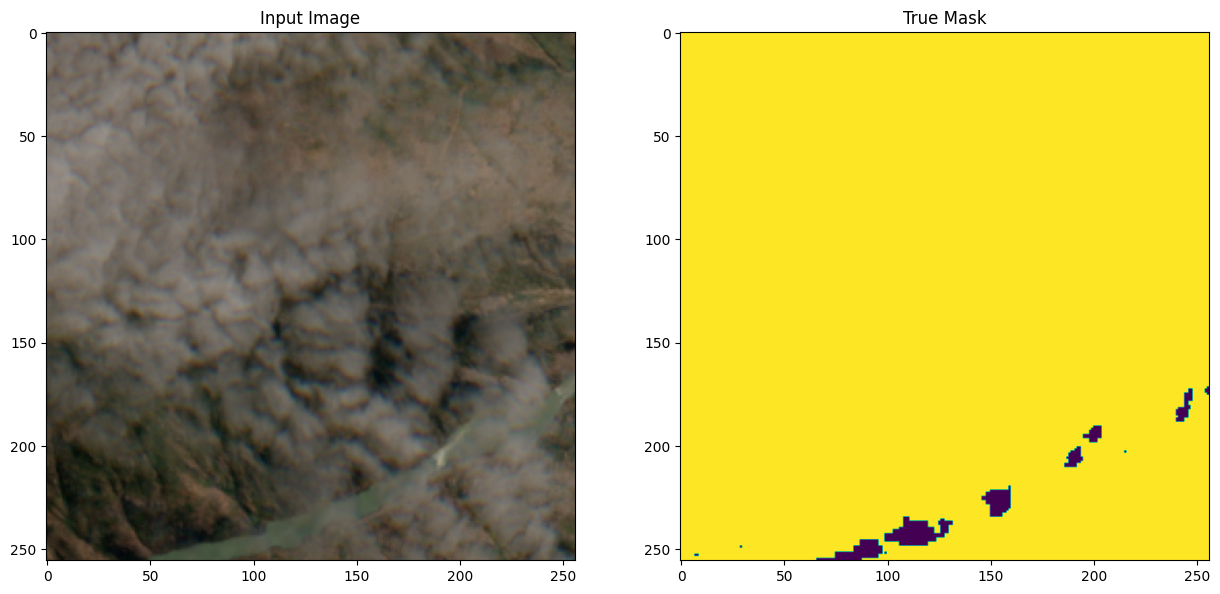

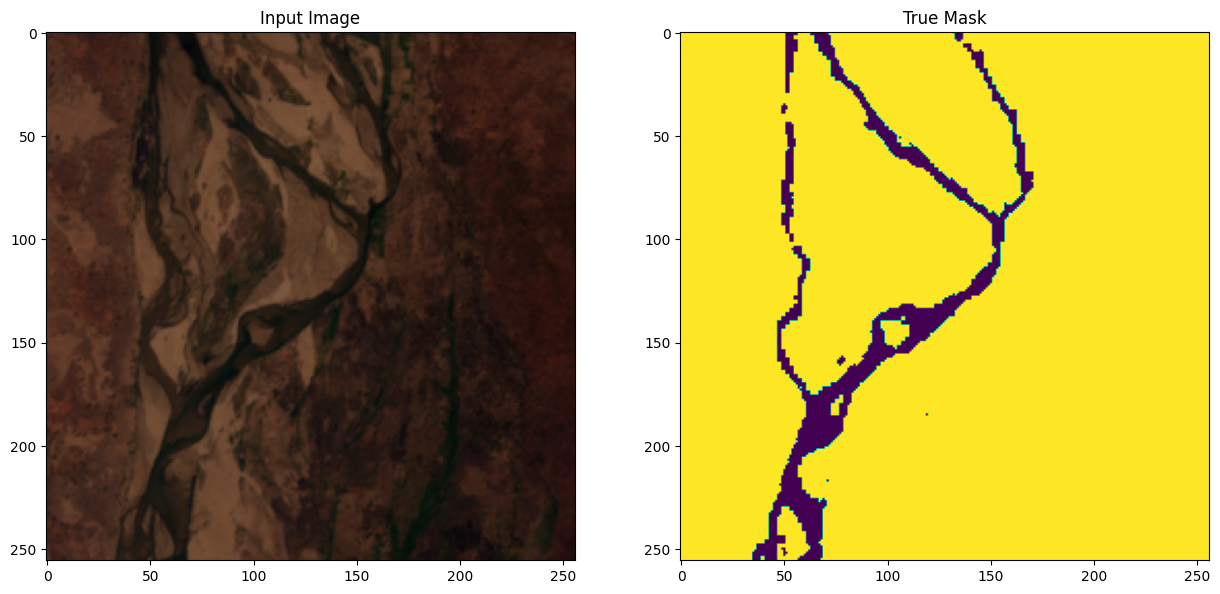

In [11]:
train_batch_img = train_generator.getitem_as_img(10)

display(train_batch_img[0][:3], train_batch_img[1][:3])

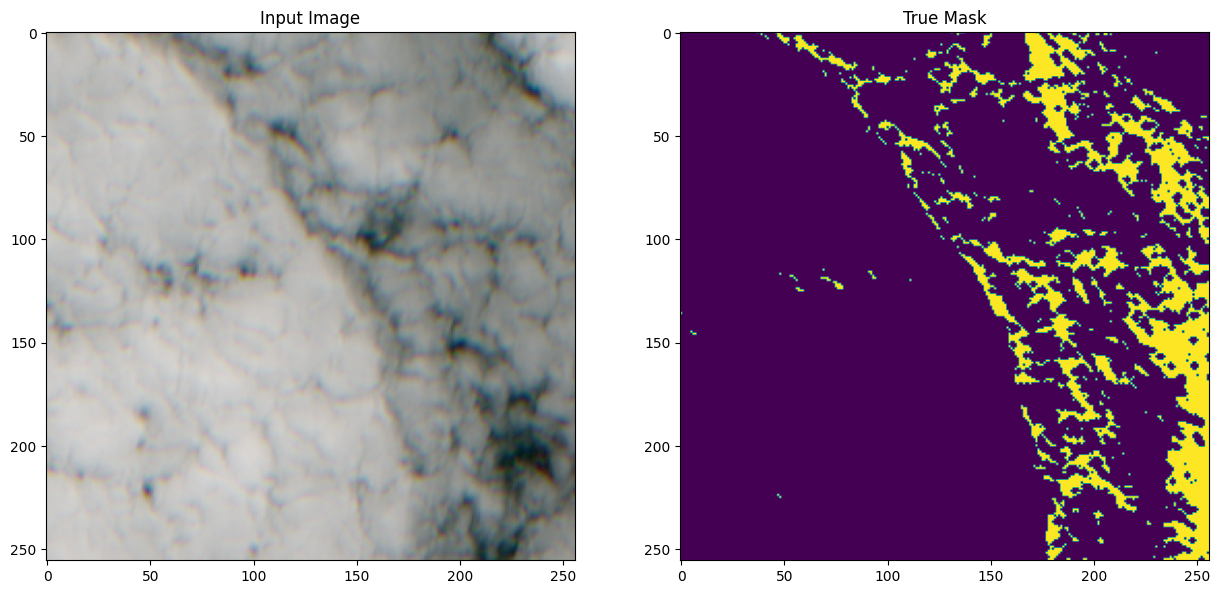

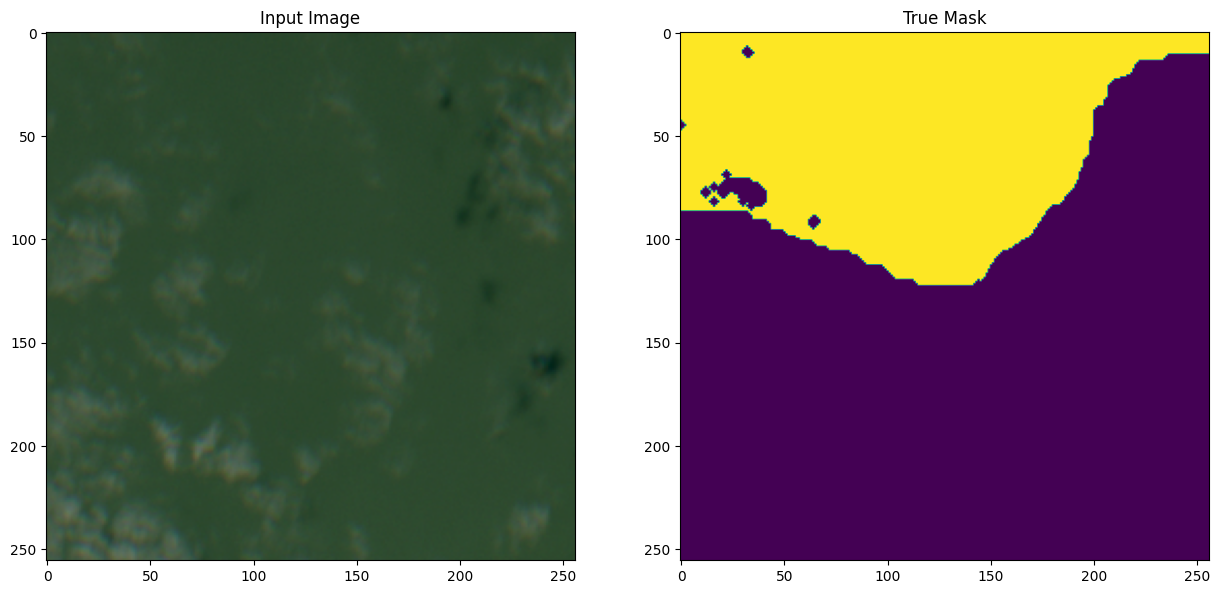

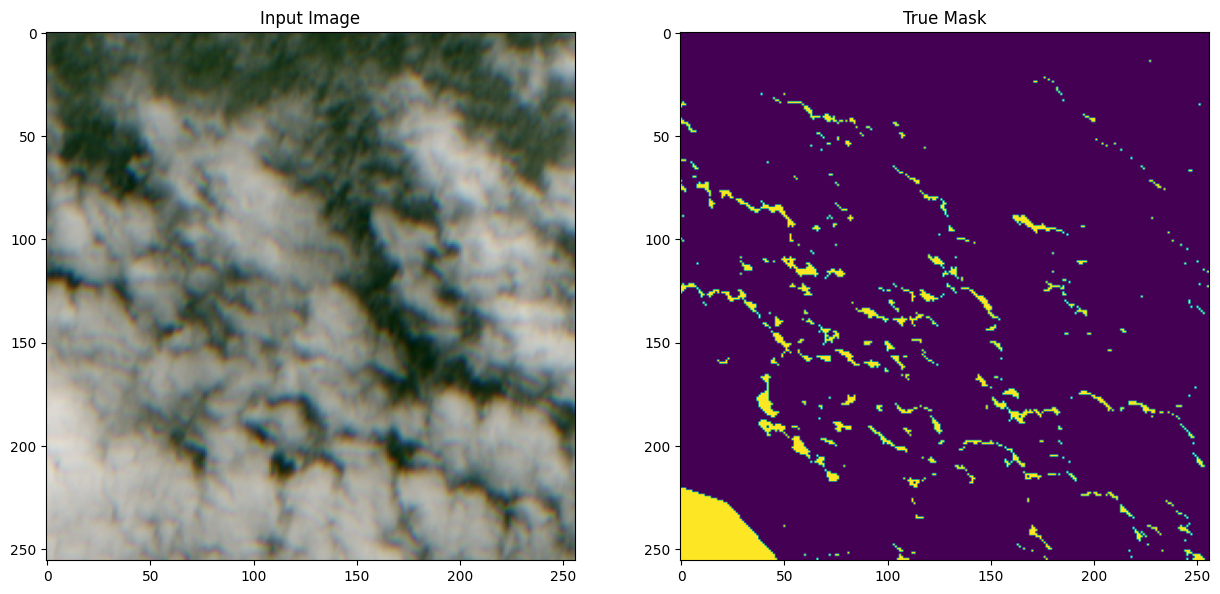

In [12]:
val_batch_img = val_generator.getitem_as_img(2)

display(val_batch_img[0][:3], val_batch_img[1][:3])

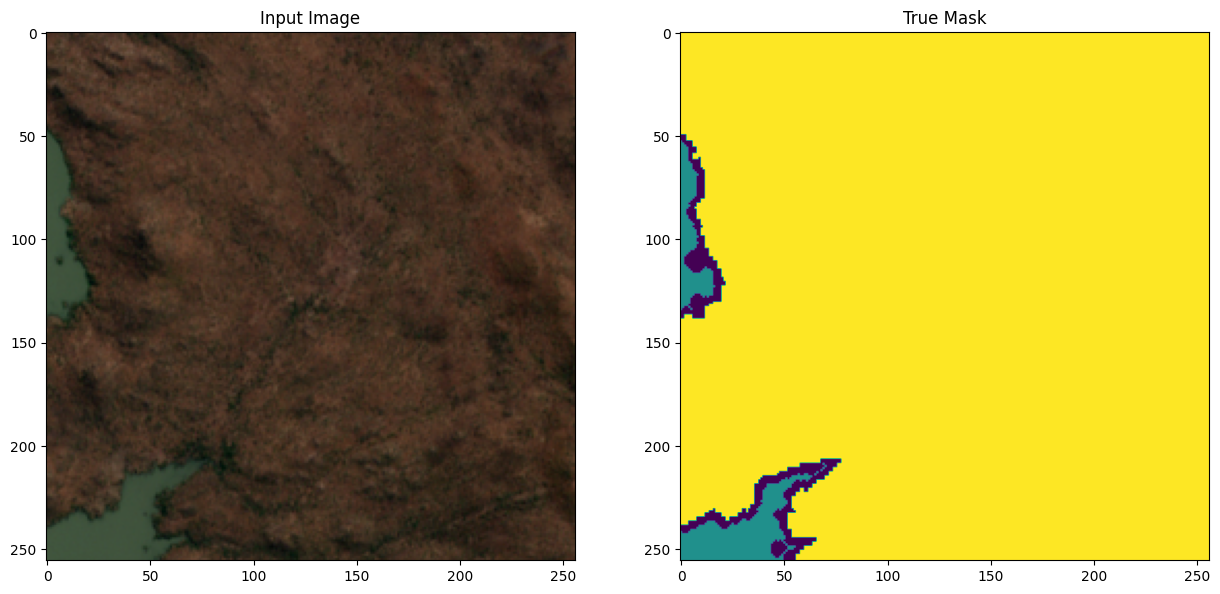

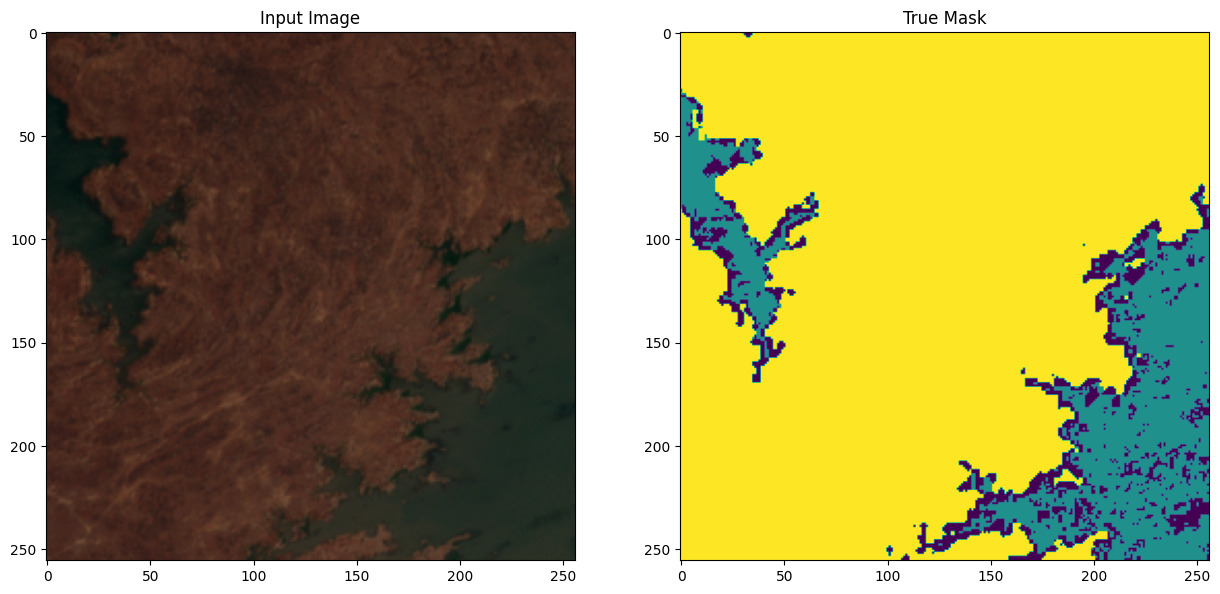

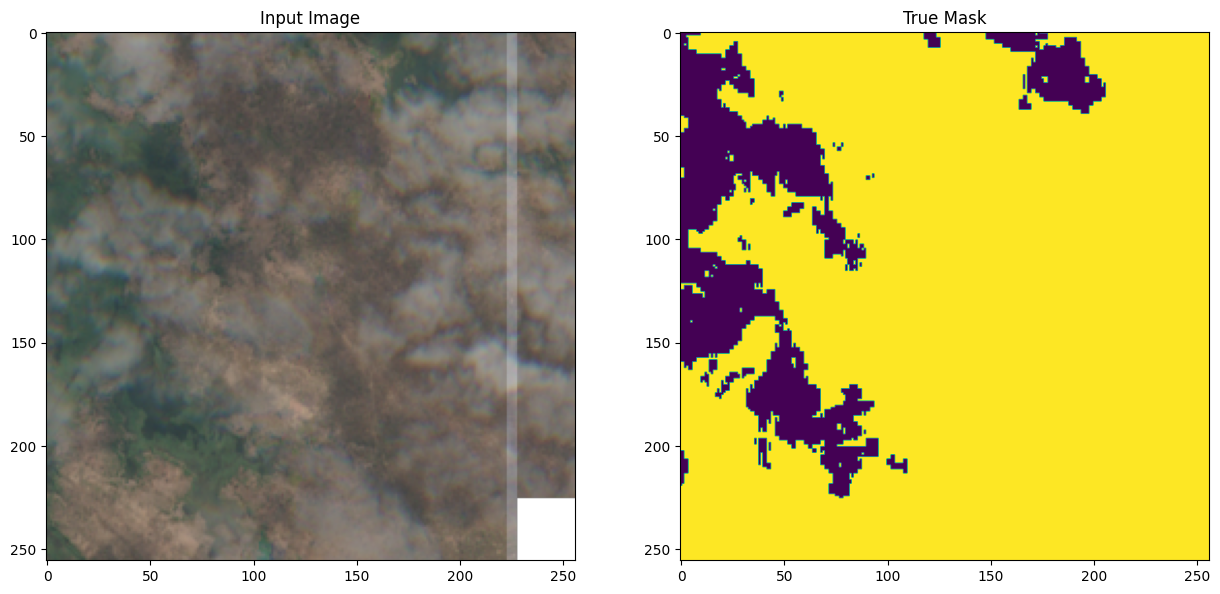

In [13]:
test_batch_img = test_generator.getitem_as_img(4)

display(test_batch_img[0][:3], test_batch_img[1][:3])

### 3. Definint the model

In [14]:
def unet_2d(input_shape, num_classes):

    # Define the input layer
    inputs = Input(input_shape)

    # Downsample layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsample layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Define the model
    model = Model(inputs=[inputs], outputs=[output])

    return model

### 5. Model training

In [ ]:
tile_size = 256
step_size = 256
saving_path = 'experiment_3'

print(f'Started at: {datetime.now()}')
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)

model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy']) # ??? alternatives
# model.summary()

early_stop = EarlyStopping(monitor='accuracy', patience=5) 

model_history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stop])

print(f'Finished at: {datetime.now()}')

Started at: 2023-04-03 16:54:42.045829
Epoch 1/100
209/209 [==============================] - 342s 2s/step - loss: 0.3174 - accuracy: 0.8638 - val_loss: 0.1632 - val_accuracy: 0.9519
Epoch 2/100
209/209 [==============================] - 317s 2s/step - loss: 0.1642 - accuracy: 0.9506 - val_loss: 0.1412 - val_accuracy: 0.9533
Epoch 3/100
209/209 [==============================] - 317s 2s/step - loss: 0.1460 - accuracy: 0.9545 - val_loss: 0.1343 - val_accuracy: 0.9577
Epoch 4/100
209/209 [==============================] - 315s 2s/step - loss: 0.1397 - accuracy: 0.9539 - val_loss: 0.1397 - val_accuracy: 0.9560
Epoch 5/100
209/209 [==============================] - 315s 2s/step - loss: 0.1355 - accuracy: 0.9567 - val_loss: 0.1094 - val_accuracy: 0.9626
Epoch 6/100
209/209 [==============================] - 315s 2s/step - loss: 0.1268 - accuracy: 0.9539 - val_loss: 0.1368 - val_accuracy: 0.9510
Epoch 7/100
209/209 [==============================] - 316s 2s/step - loss: 0.1448 - accuracy: 0.

In [ ]:
# saving model
model_name = f'{tile_size}_{step_size}_first_run'
model.save(f'../models/{saving_path}/model_{model_name}.h5')

# saving model history
with open(f'../models/{saving_path}/history_{model_name}.pkl', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

# making predictions
predictions = model.predict(test_generator)

# Todo: modify/ make subclass of EvaluationMetrics that can deal with DataGenerators as input

### 6. Training Results

In [ ]:
def plot_loss_acc(plots, y_scale):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  plt.figure(figsize=(10,6))
  if 'loss' in plots:
    plt.plot(model_history.epoch, loss, 'g', label='Training Loss')
  if 'accuracy' in plots:
    plt.plot(model_history.epoch, acc, 'y', label='Training Accuracy')
  if 'val_loss' in plots:
    plt.plot(model_history.epoch, val_loss, 'r', label='Validation Loss')
  if 'val_accuracy' in plots:
    plt.plot(model_history.epoch, val_acc, 'b', label='Validation Accuracy')
  plt.title('')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  if y_scale == 'all':
    plt.ylim([0, 1])
  elif y_scale == 'loss':
    plt.ylim([0, 25])
  else:
    plt.ylim([0.8, 1])
  plt.legend()

  plt.show()



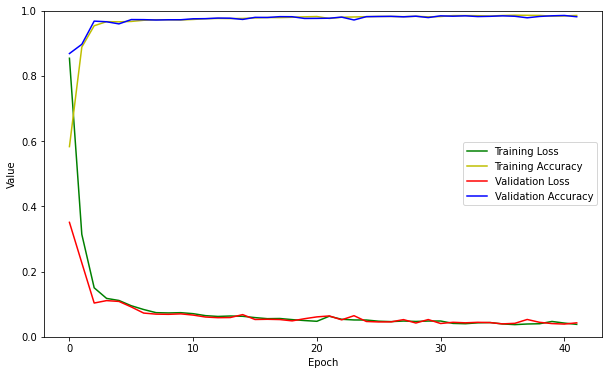

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all') ### val_loss not showing => does not fit on scale

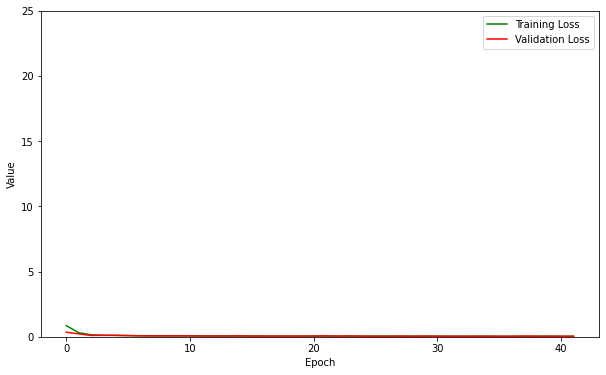

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss')

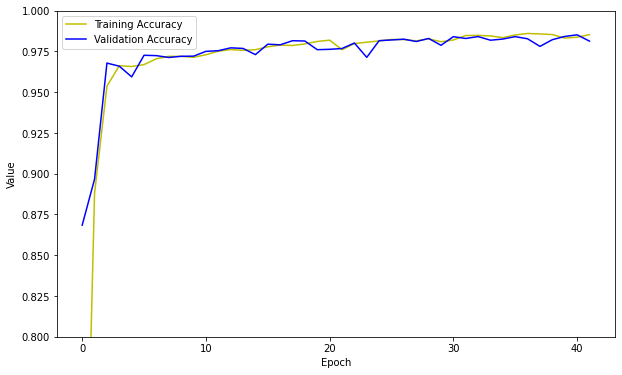

In [ ]:
plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy')